Load in existing feature and expression datasets.

In [2]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = expression[:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

In [3]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. We also ensure that we take technical factors with limited variance.

In [4]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

In [5]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


In [6]:
filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


(array([ 25.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.]),
 array([  0.        ,   7.32624621,  14.65249242,  21.97873863,
         29.30498485,  36.63123106,  43.95747727,  51.28372348,
         58.60996969,  65.9362159 ,  73.26246211]),
 <a list of 10 Patch objects>)

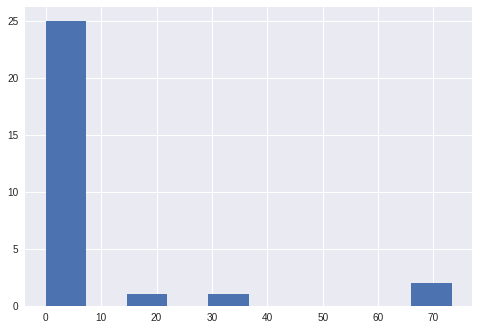

In [7]:
plt.hist(raw_technical_covariates.std(axis=0))

Take the first 20 PCs of the expression matrix.

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

# Compute feature p-values with lim using 4 different option as the cov parameter.

1. No cov parameter
2. 29 technical factors as cov parameter
3. 20 PC componenets as cov parameter
4. 20 PCs + 29 technical factors as cov parameter

In [127]:
from limix.qtl import qtl_test_lmm
from limix.plot import qqplot

pca_covariates = np.ones((sum(technical_idx),21))
pca_covariates[:,1:] = pca_expression[technical_idx]

technical_pvalues = {}
technical_and_pca_pvalues = {}
raw_pvalues = {}
pca_pvalues = {}

for f in range(100):
    single_feature = filt_tech_features[:,f].copy()
    technical_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=raw_technical_covariates)
    pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=pca_covariates)
    technical_and_pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=np.hstack([pca_covariates, raw_technical_covariates]))
    raw_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float))
    
    t_pvalues = technical_res.getPv().flatten()
    r_pvalues = raw_res.getPv().flatten()
    tp_pvalues = technical_and_pca_res.getPv().flatten()
    p_pvalues = pca_res.getPv().flatten()

    
    technical_pvalues[f] = t_pvalues
    raw_pvalues[f] = r_pvalues
    pca_pvalues[f] = p_pvalues
    technical_and_pca_pvalues[f] = tp_pvalues
    
    if f % 10 == 0:
        print (f,estimate_lambda(r_pvalues),estimate_lambda(t_pvalues), estimate_lambda(p_pvalues), estimate_lambda(tp_pvalues) )

0 5.46848233316 1.80257445307 0.600189423805 0.722492792267
10 8.74940439828 4.23777331956 2.50852415722 2.80098219156
20 24.6940011483 10.1714754863 2.90992534588 1.71945249886
30 12.3496215887 11.4720524619 1.52546428506 1.22114894388
40 22.4487064733 14.8036894126 2.19000182536 2.05110158733
50 8.02955981764 5.95237178331 2.42762184906 1.91381202129
60 8.78735650829 2.06143410598 2.61842841526 3.32250478382
70 17.2397969573 6.43333693743 2.16282095606 2.13180470532
80 9.04221322893 3.74731651083 1.22036998767 1.06124153658
90 1.68622371819 2.30524327159 1.7474501404 2.14487194976


In [129]:
full_technical_pvalues = []
full_technical_and_pca_pvalues = []
full_raw_pvalues = []
full_pca_pvalues = []

for f in range(100):
    full_technical_pvalues.extend(technical_pvalues[f].tolist())
    full_raw_pvalues.extend(raw_pvalues[f].tolist())
    full_pca_pvalues.extend(pca_pvalues[f].tolist())
    full_technical_and_pca_pvalues.extend(technical_and_pca_pvalues[f].tolist())

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


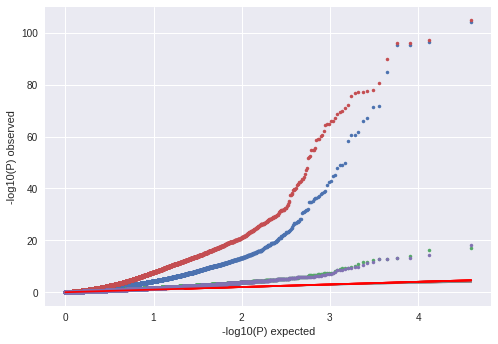

In [130]:
qqplot(np.array(full_technical_pvalues))
qqplot(np.array(full_technical_and_pca_pvalues))
qqplot(np.array(full_raw_pvalues))
qqplot(np.array(full_pca_pvalues))

Calculating p-values using lim with using different covariance sets:
* red - raw. $\lambda = 7.8$
* blue - 29 technical factors. $\lambda = 4.79$
* green - 20 PC componenets. $\lambda = 1.72$
* purple - 20 PCs + 29 technical factors. $\lambda = 1.80$

In [133]:
print (estimate_lambda(np.array(full_raw_pvalues)))
print (estimate_lambda(np.array(full_technical_pvalues)))
print (estimate_lambda(np.array(full_pca_pvalues)))
print (estimate_lambda(np.array(full_technical_and_pca_pvalues)))



7.82232071361
4.78527526675
1.72031551209
1.80022358328


We can see that the much of the inflation disappears when using the first 20 PCs as covariates. There is not much difference when then including the technical factors.

# How does this change when using different numbers of PCs?

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_expression = pca.fit_transform(expression)

pca_covariates = np.ones(shape=(len(phenotype_idx),51))
pca_covariates[:,1:] = pca_expression

In [34]:
print (pca_covariates.shape)

(274, 51)


In [35]:
from limix.qtl import qtl_test_lmm
lambdas = []
full_pvalues = {}
for pc in range(50):
    pca_pvalues = {}

    for f in range(100):
        single_feature = filt_features[:,f].copy()
        
        pca_res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=pca_covariates[:,:pc+2])
        p_pvalues = pca_res.getPv().flatten()
        pca_pvalues[f] = p_pvalues


    full_pca_pvalues = []
    for f in range(100):
        full_pca_pvalues.extend(pca_pvalues[f].tolist())
    lamb = estimate_lambda(full_pca_pvalues)
    lambdas.append(lamb)
    full_pvalues[pc] = full_pca_pvalues 
    print (pc,lamb)

0 5.45166502851
1 4.87696893382
2 4.96245758771
3 3.98806301789
4 3.59716338083
5 3.20797424881
6 3.05877643992
7 2.82870951226
8 2.73806278456
9 2.63066974036
10 2.536759133
11 2.380045155
12 2.28785206919
13 2.19147801631
14 2.09249404841
15 2.05351661046
16 1.92869204239
17 1.92221267691
18 1.87370037541
19 1.79578035101
20 1.81117577924
21 1.7910039445
22 1.74414913711
23 1.75785578902
24 1.70752040236
25 1.67246719521
26 1.66183569835
27 1.65702128922
28 1.68458367936
29 1.66985532063
30 1.6463485577
31 1.64708970363
32 1.65919291016
33 1.66790511119
34 1.63633808437
35 1.63846995714
36 1.63564852014
37 1.598515561
38 1.61223594391
39 1.59311296427
40 1.59055128044
41 1.56696636889
42 1.53648337022
43 1.51646521431
44 1.51213195302
45 1.52419717897
46 1.5470516086
47 1.52760805252
48 1.53511897022
49 1.54287465833


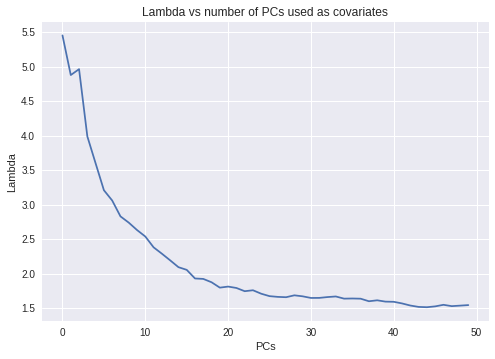

In [215]:
plt.plot(lambdas)
plt.title("Lambda vs number of PCs used as covariates")
plt.xlabel("PCs")
plt.ylabel("Lambda")

There seems to be a minimum at 30 PCs with lambda ~ 1.5.

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


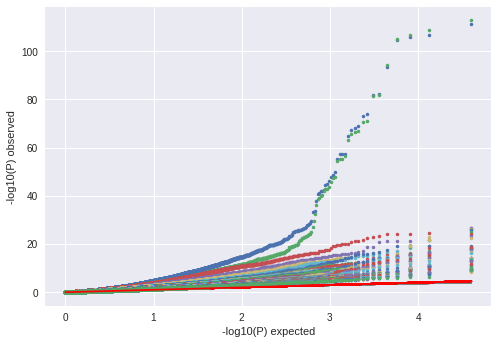

In [24]:
for pc in range(50):
    qqplot(np.array(full_pvalues[pc]))

# Feature p-values after regressing out known technical and PC factors

We extend sklean Linear regression again

In [37]:
from sklearn import linear_model
from scipy import stats
import numpy as np
import pdb


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self).__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

Compute the first 50 PCs of the expression matrix.

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_expression = pca.fit_transform(expression)
filt_pca_expression = pca_expression[technical_idx]

In [103]:
X = np.ones(shape=(raw_technical_covariates.shape[0],filt_pca_expression.shape[1] + raw_technical_covariates.shape[1] + 1))
X[:,1:filt_pca_expression.shape[1] + 1] = filt_pca_expression
X[:, 51:] = raw_technical_covariates


Using first 5 PCs

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


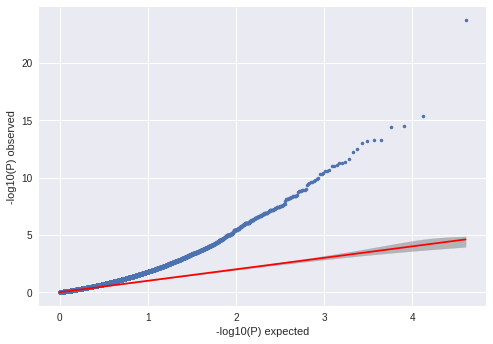

In [249]:
full_pvalues = {}
for f in range(100):
    
    lr = LinearRegression()
    res = lr.fit(X[:,:6],filt_tech_features[:,f])
    eps = res.predict(X[:,:6]) - filt_tech_features[:,f]

    residual_lr = LinearRegression()

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_full_pvalues = []
for f in range(100):
    all_full_pvalues.extend(full_pvalues[f])
    

qqplot(np.array(all_full_pvalues))

In [250]:
estimate_lambda(np.array(all_full_pvalues))

1.5197814324424652

How does this depend on the number of PCs used?

In [239]:
pc_pvalues = {}
pc_lambdas = []
for pc in range(50):
    print (pc)
    feature_pvalues = {}
    for f in range(100):
        
        residual_lr = LinearRegression()
        res = residual_lr.fit(X[:,:pc+2],filt_tech_features[:,f])
        eps = res.predict(X[:,:pc+2]) - filt_tech_features[:,f]
        
        
        pvalues = []
        for i in range(200):
            pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
            pvalues.append(pvalue)
            
        feature_pvalues[f] = pvalues
        
        

        all_full_pvalues = []
    for f in range(100):
        all_full_pvalues.extend(feature_pvalues[f])

    pc_lambdas.append(estimate_lambda(np.array(all_full_pvalues)))
    pc_pvalues[pc] = all_full_pvalues 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


KeyboardInterrupt: 

Looking for associations with the residuals after regression out first x PCs

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


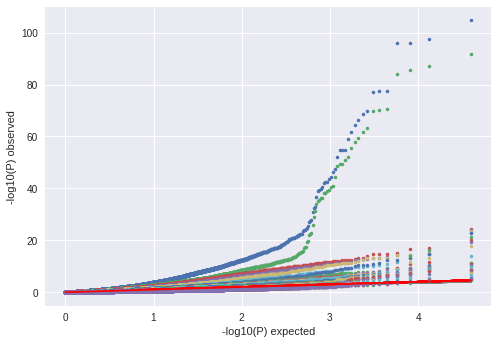

In [242]:
for pc in range(28):
    qqplot(np.array(pc_pvalues[pc]))

QQ plots of association with residuals after regressing a the first for x PCs. x varys from 0 to 28. Each colour represents a different PC.

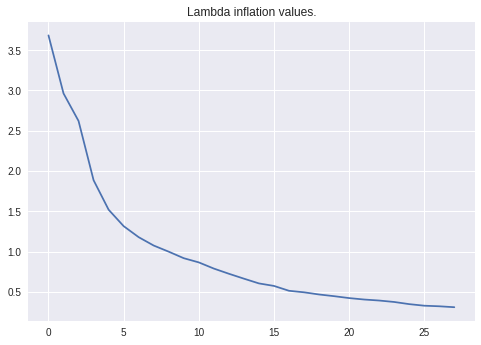

In [259]:
plt.title("Lambda inflation values.")
plt.plot(pc_lambdas)

Lambda as a function of number of PCs used.

# P-values using the expression matrix as G

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:310: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


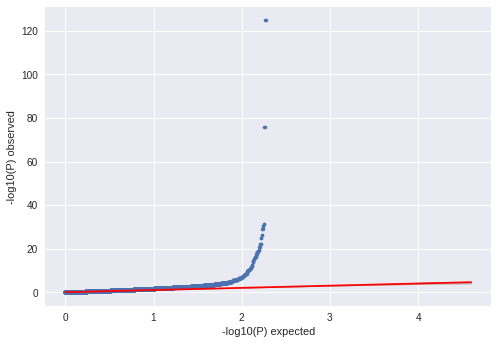

In [329]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

G = filt_tech_expression.copy()
K = corr2_coeff(G,G)

full_pvalues = []
for f in range(100):
    res = qtl_test_lmm(filt_tech_expression[:,f], filt_tech_expression.astype(float),K=K.astype(float))
    pvalues = res.getPv()
    full_pvalues.extend(pvalues)
    


qqplot(np.array(full_pvalues).flatten())

In [323]:
np.argsort(np.array(full_pvalues).flatten())

array([    0,  4824, 17487, ..., 13156, 15961,  7773])